# Coupled GAN (CoGAN)

## Theory

$$\max_{g_1, g_2} \min_{f_1, f_2} V(f_1, f_2, g_1, g_2),$$ 

subject to 

$$\mathbf{\theta}_{g_1^{(i)}} = \mathbf{\theta}_{g_2^{(i)}}, i = 1, 2, \cdots, k$$

$$\mathbf{\theta}_{f_1^{(n_1 - j)}} = \mathbf{\theta}_{g_2^{(n_2 - j)}}, j = 0, 1, \cdots, l - 1$$

where

$$V(f_1, f_2, g_1, g_2) = \mathbb{E}_{\mathbf{x}_1 \sim p_{data}(\mathbf{x}_1)} [-\log f_1(\mathbf{x}_1)] + \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}(\mathbf{z})} [-\log (1 - f_1(g_1(\mathbf{z})))] + \mathbb{E}_{\mathbf{x}_2 \sim p_{data}(\mathbf{x}_2)} [-\log f_2(\mathbf{x}_2)] + \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}(\mathbf{z})} [-\log (1 - f_2(g_2(\mathbf{z})))]$$

+ A method that extends GAN so that it could learn joint distribution, by only needing samples from the marginals. Very useful as collecting representing samples of joint distribution is costly due to curse of dimensionality.

+ Add a constraint such that high level representations of data are shared. Specifically, we constraint our networks to have the same weights on several layers. For discriminator, it should be the last layers. For generator, it should be the first layers, as generator in GAN solves inverse problem: from latent representation $z$ to image $X$.

+ If we want to learn joint distribution of $K$ domains, then we need to use $2K$ neural nets, as for each domain we need a discriminator and a generator.

## Advantages and Limitations


## References

Ming-Yu Liu and Oncel Tuzel, Coupled generative adversarial networks, NIPS 2016.

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scipy.ndimage.interpolation

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True, source_url= 'http://yann.lecun.com/exdb/mnist/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
mb_size = 128
X_dim = mnist.train.images.shape[1]
Z_dim = 100
h_dim = 128

eps = 1e-8
lr = 1e-3

+ learn joint distribution of two domains of MNIST data: normal MNIST data and rotated MNIST data (90 degree).

In [4]:
X_train = mnist.train.images
half = int(X_train.shape[0] / 2)

# Real image
X_train1 = X_train[:half]
# Rotated image
X_train2 = X_train[half:].reshape(-1, 28, 28)
X_train2 = scipy.ndimage.interpolation.rotate(X_train2, 90, axes=(1, 2))
X_train2 = X_train2.reshape(-1, 28*28)

# Cleanup
del X_train

+ Initialization

In [5]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [6]:
X1 = tf.placeholder(tf.float32, shape=[None, X_dim])
X2 = tf.placeholder(tf.float32, shape=[None, X_dim])

D1_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D1_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D2_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D2_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D1_W1, D2_W1, D1_b1, D2_b1]
theta_D_shared = [D_W2, D_b2]

Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G1_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G1_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

G2_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G2_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G1_W2, G2_W2, G1_b2, G2_b2]
theta_G_shared = [G_W1, G_b1]

+ Latent variable $z$ can sample from any distributions, e.g., uniform distribution or normal distribution.

In [7]:
def sample_X(X, size):
    start_idx = np.random.randint(0, X.shape[0]-size)
    
    return X[start_idx:start_idx+size]

def sample_Z(m, n):
    
    return np.random.uniform(-1., 1., size=[m, n])

+ Generator $G$ and Discriminator $D$ are two networks, e.g., ConvNets or Multi-Layer Perceptrons (MLP). Here, Two-Layer Full-Connected Forward Feedback NN.

In [8]:
def generator(z):
    h = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G1 = tf.nn.sigmoid(tf.matmul(h, G1_W2) + G1_b2)
    G2 = tf.nn.sigmoid(tf.matmul(h, G2_W2) + G2_b2)
    
    return G1, G2

def discriminator(X1, X2):
    h1 = tf.nn.relu(tf.matmul(X1, D1_W1) + D1_b1)
    h2 = tf.nn.relu(tf.matmul(X2, D2_W1) + D2_b1)
    D1_out = tf.nn.sigmoid(tf.matmul(h1, D_W2) + D_b2)
    D2_out = tf.nn.sigmoid(tf.matmul(h2, D_W2) + D_b2)
    
    return D1_out, D2_out

In [9]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [10]:
G1_sample, G2_sample = generator(Z)

D1_real, D2_real = discriminator(X1, X2)
D1_fake, D2_fake = discriminator(G1_sample, G2_sample)

+ Loss functions

In [11]:
D1_loss = -tf.reduce_mean(tf.log(D1_real + eps) + tf.log(1. - D1_fake + eps))
D2_loss = -tf.reduce_mean(tf.log(D2_real + eps) + tf.log(1. - D2_fake + eps))
D_loss = D1_loss + D2_loss

G1_loss = -tf.reduce_mean(tf.log(D1_fake + eps))
G2_loss = -tf.reduce_mean(tf.log(D2_fake + eps))
G_loss = G1_loss + G2_loss

# D optimizer
D_opt = tf.train.AdamOptimizer(learning_rate=lr)
# Compute the gradients for a list of variables.
D_gv = D_opt.compute_gradients(D_loss, theta_D)
D_shared_gv = D_opt.compute_gradients(D_loss, theta_D_shared)
# Average by halfing the shared gradients
D_shared_gv = [(0.5 * x[0], x[1]) for x in D_shared_gv]
# Update
D_solver = tf.group(D_opt.apply_gradients(D_gv), D_opt.apply_gradients(D_shared_gv))

# G optimizer
G_opt = tf.train.AdamOptimizer(learning_rate=lr)
# Compute the gradients for a list of variables.
G_gv = G_opt.compute_gradients(G_loss, theta_G)
G_shared_gv = G_opt.compute_gradients(G_loss, theta_G_shared)
# Average by halfing the shared gradients
G_shared_gv = [(0.5 * x[0], x[1]) for x in G_shared_gv]
# Update
G_solver = tf.group(G_opt.apply_gradients(G_gv), G_opt.apply_gradients(G_shared_gv))

+ Here, $k = 1$

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('GAN-CoGAN/'):
    os.makedirs('GAN-CoGAN/')

avg_costs = {'discriminator': [], 'generator': []} 

i = 0

for it in range(50000):
    X1_mb, X2_mb = sample_X(X_train1, mb_size), sample_X(X_train2, mb_size)
    Z_mb = sample_Z(mb_size, Z_dim)

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X1: X1_mb, X2: X2_mb, Z: Z_mb})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D_loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print('\n')
        
        n_sample = 8
        
        sample1, sample2 = sess.run([G1_sample, G2_sample], feed_dict={Z: sample_Z(n_sample, Z_dim)})
        samples = np.vstack([sample1, sample2])

        fig = plot(samples)
        plt.savefig('GAN-CoGAN/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
        
        avg_costs['discriminator'].append(D_loss_curr / n_sample)
        avg_costs['generator'].append(G_loss_curr / n_sample)

Iter: 0
D_loss: 3.372
G_loss: 3.098


Iter: 1000
D_loss: 0.01523
G_loss: 15.13


Iter: 2000
D_loss: 0.08032
G_loss: 10.89


Iter: 3000
D_loss: 0.142
G_loss: 13.67


Iter: 4000
D_loss: 0.2575
G_loss: 11.56


Iter: 5000
D_loss: 0.303
G_loss: 10.42


Iter: 6000
D_loss: 0.4587
G_loss: 9.016


Iter: 7000
D_loss: 0.5359
G_loss: 9.89


Iter: 8000
D_loss: 0.8774
G_loss: 7.91


Iter: 9000
D_loss: 0.9577
G_loss: 7.86


Iter: 10000
D_loss: 0.9627
G_loss: 7.469


Iter: 11000
D_loss: 0.9878
G_loss: 6.277


Iter: 12000
D_loss: 1.105
G_loss: 6.466


Iter: 13000
D_loss: 1.359
G_loss: 5.835


Iter: 14000
D_loss: 1.34
G_loss: 5.692


Iter: 15000
D_loss: 1.074
G_loss: 5.501


Iter: 16000
D_loss: 1.228
G_loss: 5.238


Iter: 17000
D_loss: 1.183
G_loss: 5.121


Iter: 18000
D_loss: 1.199
G_loss: 5.42


Iter: 19000
D_loss: 1.273
G_loss: 4.762


Iter: 20000
D_loss: 1.306
G_loss: 5.044


Iter: 21000
D_loss: 1.165
G_loss: 4.924


Iter: 22000
D_loss: 0.9769
G_loss: 5.618


Iter: 23000
D_loss: 1.098
G_loss: 5.224


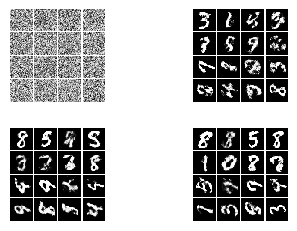

In [13]:
plt.figure()

ax = plt.subplot(221)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan1 = plt.imread('GAN-CoGAN/000.png')
plt.imshow(gan1, cmap='Greys_r')

ax = plt.subplot(222)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan2 = plt.imread('GAN-CoGAN/015.png')
plt.imshow(gan2, cmap='Greys_r')

ax = plt.subplot(223)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan3 = plt.imread('GAN-CoGAN/030.png')
plt.imshow(gan3, cmap='Greys_r')

ax = plt.subplot(224)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan4 = plt.imread('GAN-CoGAN/045.png')
plt.imshow(gan4, cmap='Greys_r')

plt.show()

+ Performance estimation

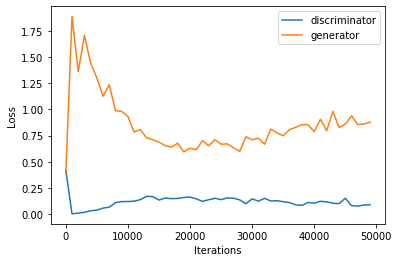

In [14]:
# plotting the learning curves
plt.figure()
plt.plot(np.arange(len(avg_costs['discriminator']))*1000, avg_costs['discriminator'], label='discriminator')
plt.plot(np.arange(len(avg_costs['generator']))*1000, avg_costs['generator'], label='generator')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')
plt.legend()
plt.show()